In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from network_revised import Inputs_TwoDots, build_network

In [2]:
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [3]:
def scan_coherence_spikes(coherences=[0.0, 0.032, 0.064, 0.128, 0.256, 0.512],  # hanks 2014
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   ramp=1,
                   threshold=0.5,
                   relative=0,
                   end_condition="action",
                   t_start=0.3,
                   t_end=0.3,
                   t_stop=5.0,
                   name="scan_coherence_spikes"):
    
    inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=perception_seed)

    dfs = []
    dfs_end = []
    for coherence in coherences:
        inputs.create(coherence=coherence, correct="L")
        for trial in range(trials):
            net = build_network(inputs, seed=network_seed+trial, ramp=ramp, threshold=threshold, relative=relative, probe_spikes=True)
            sim = nengo.Simulator(net, progress_bar=False)
            choice = None
            while choice==None:
                sim.run(dt)
                if end_condition=="action" and sim.data[net.pAction][-1,0] > 0:
                    choice = "L"
                    RT = sim.trange()[-1]
                elif end_condition=="action" and sim.data[net.pAction][-1,1] > 0:
                    choice = "R"
                    RT = sim.trange()[-1]
                elif end_condition=="gate" and sim.data[net.pValue][-1,0] > sim.data[net.pGate][-1]:
                    choice = "L"
                    RT = sim.trange()[-1]
                elif end_condition=="gate" and sim.data[net.pValue][-1,1] > sim.data[net.pGate][-1]:
                    choice = "R"
                    RT = sim.trange()[-1]
                elif sim.trange()[-1] > t_stop:
                    choice = "L" if sim.data[net.pValue][-1,0] > sim.data[net.pValue][-1,1] else "R"
                    RT = sim.trange()[-1]
            correct = True if choice==inputs.correct else False
            print(f"trial {trial}, coherence {coherence}, RT {RT}, correct {correct}")
#             ramping_neuron_idx = np.argwhere(sim.data[net.pSpikes][-1,:] > 2*sim.data[net.pSpikes][0,:])
#             ramping_rates = sim.data[net.pSpikes][:,ramping_neuron_idx]
#             average_ramping_rates = np.mean(ramping_rates, axis=1).ravel()
            aligned_L_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,0] > 0.9)
#             aligned_R_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,1] > 0.8)
            ramping_rates = sim.data[net.pSpikes][:,aligned_L_neuron_idx]
            average_ramping_rates = np.mean(ramping_rates, axis=1).ravel()

            if RT > t_start:
                df = pd.DataFrame()
                df['time'] = 1000*sim.trange()
                df['coherence'] =  coherence*np.ones_like(sim.trange())
                df['trial'] =  trial*np.ones_like(sim.trange())
                df['ramp'] =  ramp*np.ones_like(sim.trange())
                df['threshold'] =  threshold*np.ones_like(sim.trange())
                df['correct'] = correct*1.0*np.ones_like(sim.trange())
                df['RT'] = RT*1.0*np.ones_like(sim.trange())
                df['firing rate'] = average_ramping_rates
                df['value L'] = sim.data[net.pValue][:,0].ravel()
                df['value R'] = sim.data[net.pValue][:,1].ravel()
                df['gate'] = sim.data[net.pGate].ravel()
                dfs.append(df)

                df2 = pd.DataFrame()
                idx = int(t_end/dt)
                df2['time'] = np.arange(-t_end/dt, 0)
                df2['coherence'] =  coherence*np.ones_like(sim.trange())[-idx:]
                df2['trial'] =  trial*np.ones_like(sim.trange())[-idx:]
                df2['ramp'] =  ramp*np.ones_like(sim.trange())[-idx:]
                df2['threshold'] =  threshold*np.ones_like(sim.trange())[-idx:]
                df2['correct'] = correct*1.0*np.ones_like(sim.trange())[-idx:]
                df2['RT'] = RT*1.0*np.ones_like(sim.trange())[-idx:]
                df2['firing rate'] = average_ramping_rates[-idx:]
                df2['value L'] = sim.data[net.pValue][:,0].ravel()[-idx:]
                df2['value R'] = sim.data[net.pValue][:,1].ravel()[-idx:]
                df2['gate'] = sim.data[net.pGate].ravel()[-idx:]
                dfs_end.append(df2)
                
    data = pd.concat(dfs, ignore_index=True)
    data_end = pd.concat(dfs_end, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    data_end.to_pickle(f"data/{name}_end.pkl")

In [4]:
def plot_spikes(name, t0=150, t1=600):
    data_start = pd.read_pickle(f"data/{name}.pkl").query("time>@t0 & time<@t1")
    data_end = pd.read_pickle(f"data/{name}_end.pkl")
    palette2 = sns.color_palette("mako_r", len(data_start['coherence'].unique()))
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=((7.08, 4)))
    sns.lineplot(data=data_start, x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][0])
    sns.lineplot(data=data_end, x='time', y='firing rate', hue="coherence", palette=palette2, ax=axes[0][1])
    sns.lineplot(data=data_start, x='time', y='value L', hue="coherence", palette=palette2, ax=axes[1][0])
    sns.lineplot(data=data_end, x='time', y='value L', hue="coherence", palette=palette2, ax=axes[1][1])
    axes[0][0].set(xlabel=None, ylabel="Firing Rate (Hz)", title="Ramping Activities (Early)")
    axes[0][1].set(xlabel=None,  ylabel=None, title="Ramping Activities (Late)")
    axes[1][0].set(xlabel="Time After Stimulus (ms)", ylabel=r"$\mathbf{\hat{x}}(t)$", title="Ramping Decision Variable (Early)")
    axes[1][1].set(xlabel="Time Before Decision (ms)", ylabel=None, title="Ramping Decision Variable (Late)")
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

trial 0, coherence 0.1, RT 1.0070000000000001, correct True
trial 1, coherence 0.1, RT 1.157, correct True
trial 2, coherence 0.1, RT 0.998, correct True
trial 3, coherence 0.1, RT 0.97, correct True
trial 4, coherence 0.1, RT 1.004, correct True
trial 5, coherence 0.1, RT 0.986, correct True
trial 6, coherence 0.1, RT 0.982, correct True
trial 7, coherence 0.1, RT 0.98, correct True
trial 8, coherence 0.1, RT 1.061, correct False
trial 9, coherence 0.1, RT 0.869, correct True
trial 10, coherence 0.1, RT 0.932, correct True
trial 11, coherence 0.1, RT 0.973, correct True
trial 12, coherence 0.1, RT 1.116, correct False
trial 13, coherence 0.1, RT 1.034, correct True
trial 14, coherence 0.1, RT 0.867, correct True
trial 15, coherence 0.1, RT 1.214, correct True
trial 16, coherence 0.1, RT 1.026, correct True
trial 17, coherence 0.1, RT 1.169, correct True
trial 18, coherence 0.1, RT 0.918, correct True
trial 19, coherence 0.1, RT 0.98, correct True
trial 20, coherence 0.1, RT 1.01900000

trial 65, coherence 0.3, RT 0.8300000000000001, correct True
trial 66, coherence 0.3, RT 0.802, correct True
trial 67, coherence 0.3, RT 0.709, correct True
trial 68, coherence 0.3, RT 0.9, correct True
trial 69, coherence 0.3, RT 0.778, correct True
trial 70, coherence 0.3, RT 0.802, correct True
trial 71, coherence 0.3, RT 0.897, correct True
trial 72, coherence 0.3, RT 0.988, correct True
trial 73, coherence 0.3, RT 0.9440000000000001, correct True
trial 74, coherence 0.3, RT 0.805, correct True
trial 75, coherence 0.3, RT 0.804, correct True
trial 76, coherence 0.3, RT 0.867, correct True
trial 77, coherence 0.3, RT 0.775, correct True
trial 78, coherence 0.3, RT 0.874, correct True
trial 79, coherence 0.3, RT 0.897, correct True
trial 80, coherence 0.3, RT 0.789, correct True
trial 81, coherence 0.3, RT 0.967, correct True
trial 82, coherence 0.3, RT 0.9480000000000001, correct True
trial 83, coherence 0.3, RT 0.833, correct True
trial 84, coherence 0.3, RT 0.834, correct True
tri

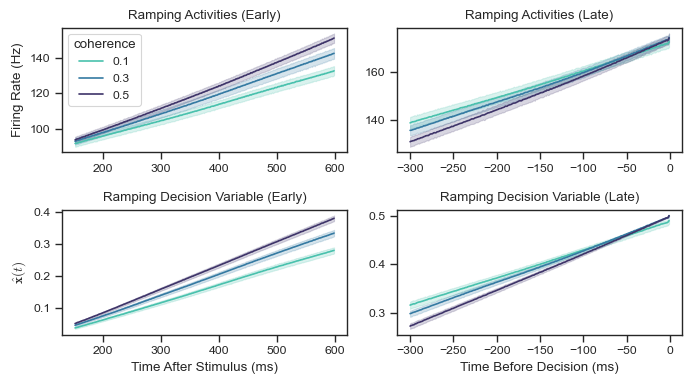

In [12]:
coherences = [0.1, 0.3, 0.5]
dt_sample = 0.02
trials = 100
end_condition = "gate"
name = f"spikes_{dt_sample}_{end_condition}"
scan_coherence_spikes(coherences=coherences, dt_sample=dt_sample, trials=trials, end_condition=end_condition, name=name)
plot_spikes(name)

trial 0, coherence 0.1, RT 1.031, correct True
trial 1, coherence 0.1, RT 1.188, correct True
trial 2, coherence 0.1, RT 1.024, correct True
trial 3, coherence 0.1, RT 0.989, correct True
trial 4, coherence 0.1, RT 1.034, correct True
trial 5, coherence 0.1, RT 1.004, correct True
trial 6, coherence 0.1, RT 0.98, correct True
trial 7, coherence 0.1, RT 1.008, correct True
trial 8, coherence 0.1, RT 1.17, correct False
trial 9, coherence 0.1, RT 0.9530000000000001, correct True
trial 10, coherence 0.1, RT 0.936, correct True
trial 11, coherence 0.1, RT 0.969, correct True
trial 12, coherence 0.1, RT 1.1480000000000001, correct False
trial 13, coherence 0.1, RT 0.9390000000000001, correct True
trial 14, coherence 0.1, RT 0.98, correct True
trial 15, coherence 0.1, RT 1.149, correct False
trial 16, coherence 0.1, RT 0.914, correct True
trial 17, coherence 0.1, RT 0.004, correct True
trial 18, coherence 0.1, RT 1.189, correct True
trial 19, coherence 0.1, RT 0.9470000000000001, correct Tru

trial 64, coherence 0.3, RT 0.849, correct True
trial 65, coherence 0.3, RT 0.81, correct True
trial 66, coherence 0.3, RT 0.907, correct True
trial 67, coherence 0.3, RT 0.755, correct True
trial 68, coherence 0.3, RT 0.877, correct True
trial 69, coherence 0.3, RT 0.8230000000000001, correct True
trial 70, coherence 0.3, RT 0.9450000000000001, correct True
trial 71, coherence 0.3, RT 1.097, correct True
trial 72, coherence 0.3, RT 0.779, correct True
trial 73, coherence 0.3, RT 0.888, correct True
trial 74, coherence 0.3, RT 0.887, correct True
trial 75, coherence 0.3, RT 0.774, correct True
trial 76, coherence 0.3, RT 0.864, correct True
trial 77, coherence 0.3, RT 0.928, correct True
trial 78, coherence 0.3, RT 0.8, correct True
trial 79, coherence 0.3, RT 0.981, correct True
trial 80, coherence 0.3, RT 0.979, correct True
trial 81, coherence 0.3, RT 0.873, correct True
trial 82, coherence 0.3, RT 0.861, correct True
trial 83, coherence 0.3, RT 0.893, correct True
trial 84, coheren

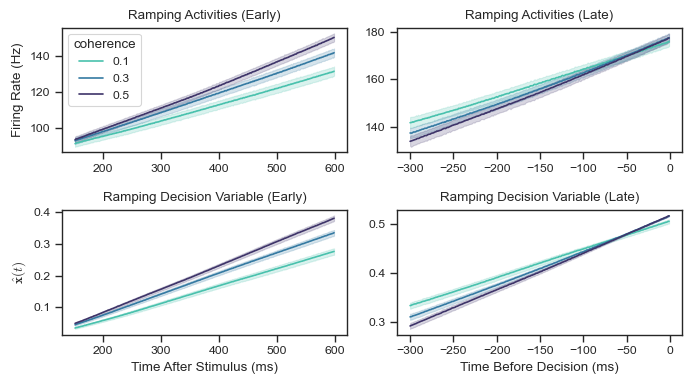

In [15]:
coherences = [0.1, 0.3, 0.5]
dt_sample = 0.02
trials = 100
end_condition = "action"
name = f"spikes_{dt_sample}_{end_condition}"
scan_coherence_spikes(coherences=coherences, dt_sample=dt_sample, trials=trials, end_condition=end_condition, name=name)
plot_spikes(name)

trial 0, coherence 0.0, RT 0.004, correct True
trial 1, coherence 0.0, RT 0.002, correct True
trial 2, coherence 0.0, RT 0.002, correct False
trial 3, coherence 0.0, RT 0.002, correct True
trial 4, coherence 0.0, RT 0.003, correct False
trial 5, coherence 0.0, RT 0.002, correct True
trial 6, coherence 0.0, RT 0.002, correct True
trial 7, coherence 0.0, RT 0.002, correct True
trial 8, coherence 0.0, RT 0.002, correct True
trial 9, coherence 0.0, RT 0.002, correct False
trial 10, coherence 0.0, RT 0.002, correct True
trial 11, coherence 0.0, RT 0.002, correct True
trial 12, coherence 0.0, RT 0.002, correct False
trial 13, coherence 0.0, RT 0.002, correct True
trial 14, coherence 0.0, RT 0.8220000000000001, correct False
trial 15, coherence 0.0, RT 0.003, correct True
trial 16, coherence 0.0, RT 0.002, correct True
trial 17, coherence 0.0, RT 0.002, correct True
trial 18, coherence 0.0, RT 0.002, correct False
trial 19, coherence 0.0, RT 0.002, correct True
trial 20, coherence 0.0, RT 0.0

trial 69, coherence 0.09, RT 0.002, correct False
trial 70, coherence 0.09, RT 0.002, correct False
trial 71, coherence 0.09, RT 0.003, correct False
trial 72, coherence 0.09, RT 0.002, correct True
trial 73, coherence 0.09, RT 0.003, correct True
trial 74, coherence 0.09, RT 0.003, correct True
trial 75, coherence 0.09, RT 0.002, correct False
trial 76, coherence 0.09, RT 0.002, correct True
trial 77, coherence 0.09, RT 0.002, correct True
trial 78, coherence 0.09, RT 0.005, correct True
trial 79, coherence 0.09, RT 0.002, correct True
trial 80, coherence 0.09, RT 0.002, correct True
trial 81, coherence 0.09, RT 0.002, correct False
trial 82, coherence 0.09, RT 0.002, correct True
trial 83, coherence 0.09, RT 0.002, correct True
trial 84, coherence 0.09, RT 0.002, correct True
trial 85, coherence 0.09, RT 0.002, correct True
trial 86, coherence 0.09, RT 0.003, correct True
trial 87, coherence 0.09, RT 0.004, correct False
trial 88, coherence 0.09, RT 0.002, correct True
trial 89, cohe

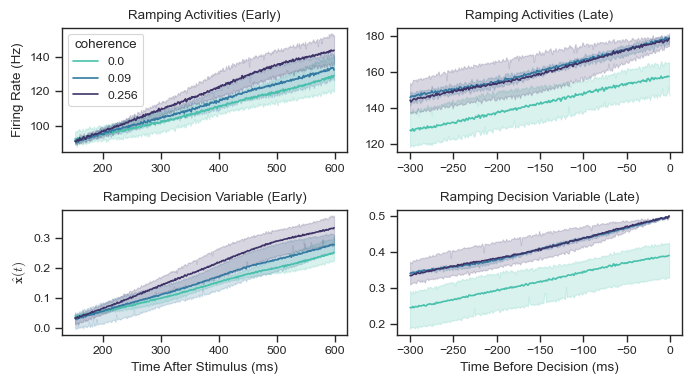

In [16]:
coherences = [0.0, 0.09, 0.256]
dt_sample = 0.02
trials = 100
end_condition = "gate"
name = f"spikes_{dt_sample}_{end_condition}"
scan_coherence_spikes(coherences=coherences, dt_sample=dt_sample, trials=trials, end_condition=end_condition, name=name)
plot_spikes(name)

trial 0, coherence 0.01, RT 1.047, correct False
trial 1, coherence 0.01, RT 1.143, correct False
trial 2, coherence 0.01, RT 0.99, correct False
trial 3, coherence 0.01, RT 0.988, correct False
trial 4, coherence 0.01, RT 1.045, correct False
trial 5, coherence 0.01, RT 1.116, correct False
trial 6, coherence 0.01, RT 0.962, correct True
trial 7, coherence 0.01, RT 0.96, correct False
trial 8, coherence 0.01, RT 1.01, correct False
trial 9, coherence 0.01, RT 1.04, correct True
trial 10, coherence 0.01, RT 1.055, correct True
trial 11, coherence 0.01, RT 1.083, correct True
trial 12, coherence 0.01, RT 1.244, correct False
trial 13, coherence 0.01, RT 0.972, correct True
trial 14, coherence 0.01, RT 1.045, correct True
trial 15, coherence 0.01, RT 0.9450000000000001, correct False
trial 16, coherence 0.01, RT 0.872, correct True
trial 17, coherence 0.01, RT 0.004, correct True
trial 18, coherence 0.01, RT 1.068, correct False
trial 19, coherence 0.01, RT 1.061, correct True
trial 20, 

trial 59, coherence 0.09, RT 1.067, correct True
trial 60, coherence 0.09, RT 1.044, correct True
trial 61, coherence 0.09, RT 0.989, correct True
trial 62, coherence 0.09, RT 1.057, correct True
trial 63, coherence 0.09, RT 0.901, correct True
trial 64, coherence 0.09, RT 0.916, correct True
trial 65, coherence 0.09, RT 1.037, correct True
trial 66, coherence 0.09, RT 0.994, correct True
trial 67, coherence 0.09, RT 0.929, correct True
trial 68, coherence 0.09, RT 0.8290000000000001, correct False
trial 69, coherence 0.09, RT 1.116, correct True
trial 70, coherence 0.09, RT 0.908, correct True
trial 71, coherence 0.09, RT 1.008, correct False
trial 72, coherence 0.09, RT 1.041, correct True
trial 73, coherence 0.09, RT 0.961, correct True
trial 74, coherence 0.09, RT 1.125, correct True
trial 75, coherence 0.09, RT 1.044, correct True
trial 76, coherence 0.09, RT 1.037, correct True
trial 77, coherence 0.09, RT 1.059, correct True
trial 78, coherence 0.09, RT 0.912, correct True
trial

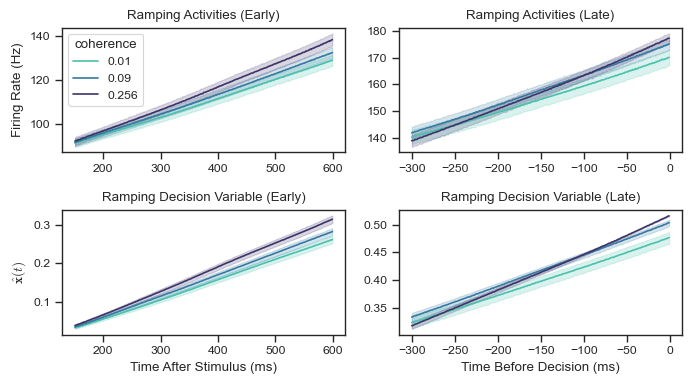

In [17]:
coherences = [0.01, 0.09, 0.256]
dt_sample = 0.02
trials = 100
end_condition = "action"
name = f"spikes_{dt_sample}_{end_condition}"
scan_coherence_spikes(coherences=coherences, dt_sample=dt_sample, trials=trials, end_condition=end_condition, name=name)
plot_spikes(name)

trial 0, coherence 0.01, RT 1.147, correct True
trial 1, coherence 0.01, RT 1.305, correct False
trial 2, coherence 0.01, RT 0.983, correct False
trial 3, coherence 0.01, RT 1.114, correct False
trial 4, coherence 0.01, RT 0.978, correct False
trial 5, coherence 0.01, RT 0.906, correct False
trial 6, coherence 0.01, RT 1.073, correct False
trial 7, coherence 0.01, RT 1.093, correct False
trial 8, coherence 0.01, RT 1.059, correct False
trial 9, coherence 0.01, RT 1.053, correct True
trial 10, coherence 0.01, RT 0.9420000000000001, correct False
trial 11, coherence 0.01, RT 1.0050000000000001, correct True
trial 12, coherence 0.01, RT 0.9540000000000001, correct False
trial 13, coherence 0.01, RT 0.935, correct True
trial 14, coherence 0.01, RT 1.0130000000000001, correct False
trial 15, coherence 0.01, RT 1.124, correct True
trial 16, coherence 0.01, RT 1.0230000000000001, correct True
trial 17, coherence 0.01, RT 0.004, correct True
trial 18, coherence 0.01, RT 1.236, correct False
tr

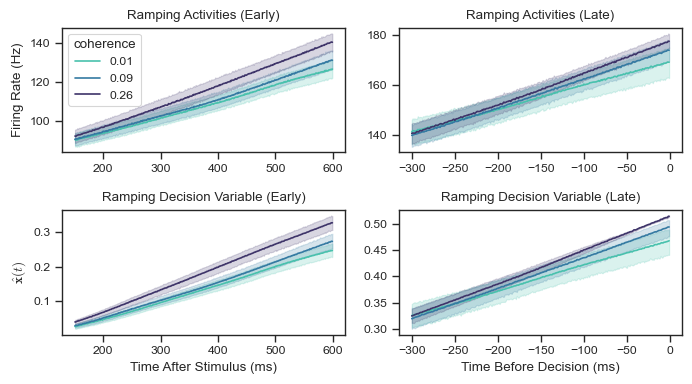

In [18]:
coherences = [0.01, 0.09, 0.26]
dt_sample = 0.03
trials = 30
end_condition = "action"
name = f"spikes_{dt_sample}_{end_condition}"
scan_coherence_spikes(coherences=coherences, dt_sample=dt_sample, trials=trials, end_condition=end_condition, name=name)
plot_spikes(name)

trial 0, coherence 0.01, RT 1.115, correct False
trial 1, coherence 0.01, RT 0.987, correct False
trial 2, coherence 0.01, RT 1.104, correct False
trial 3, coherence 0.01, RT 0.973, correct True
trial 4, coherence 0.01, RT 1.034, correct False
trial 5, coherence 0.01, RT 1.112, correct True
trial 6, coherence 0.01, RT 1.119, correct True
trial 7, coherence 0.01, RT 1.01, correct False
trial 8, coherence 0.01, RT 1.117, correct True
trial 9, coherence 0.01, RT 0.999, correct False
trial 10, coherence 0.01, RT 1.064, correct True
trial 11, coherence 0.01, RT 1.025, correct True
trial 12, coherence 0.01, RT 0.966, correct False
trial 13, coherence 0.01, RT 1.069, correct True
trial 14, coherence 0.01, RT 1.058, correct True
trial 15, coherence 0.01, RT 1.098, correct True
trial 16, coherence 0.01, RT 1.045, correct False
trial 17, coherence 0.01, RT 0.004, correct True
trial 18, coherence 0.01, RT 0.986, correct True
trial 19, coherence 0.01, RT 0.892, correct True
trial 20, coherence 0.0

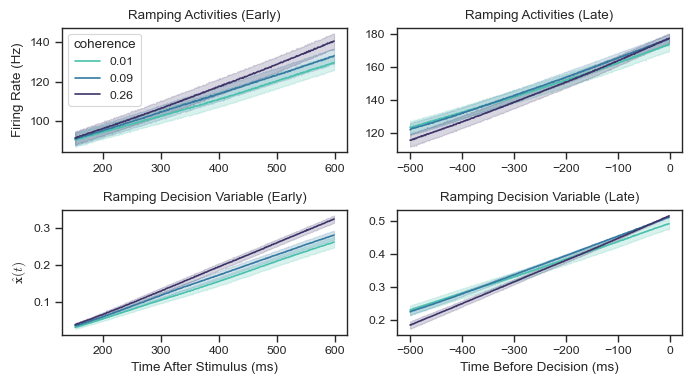

In [19]:
coherences = [0.01, 0.09, 0.26]
dt_sample = 0.01
trials = 30
end_condition = "action"
name = f"spikes_{dt_sample}_{end_condition}"
scan_coherence_spikes(coherences=coherences, dt_sample=dt_sample, trials=trials, end_condition=end_condition, name=name,
                     t_start=0.5, t_end=0.5)
plot_spikes(name)

trial 0, coherence 0.01, RT 0.854, correct False
trial 1, coherence 0.01, RT 0.8300000000000001, correct True
trial 2, coherence 0.01, RT 0.9480000000000001, correct False
trial 3, coherence 0.01, RT 0.9560000000000001, correct False
trial 4, coherence 0.01, RT 1.067, correct True
trial 5, coherence 0.01, RT 1.043, correct False
trial 6, coherence 0.01, RT 0.922, correct True
trial 7, coherence 0.01, RT 1.033, correct False
trial 8, coherence 0.01, RT 0.85, correct True
trial 9, coherence 0.01, RT 1.067, correct True
trial 10, coherence 0.01, RT 1.0210000000000001, correct True
trial 11, coherence 0.01, RT 0.886, correct False
trial 12, coherence 0.01, RT 0.971, correct True
trial 13, coherence 0.01, RT 1.0210000000000001, correct True
trial 14, coherence 0.01, RT 0.9480000000000001, correct True
trial 15, coherence 0.01, RT 1.08, correct True
trial 16, coherence 0.01, RT 0.9420000000000001, correct True
trial 17, coherence 0.01, RT 0.004, correct True
trial 18, coherence 0.01, RT 1.09

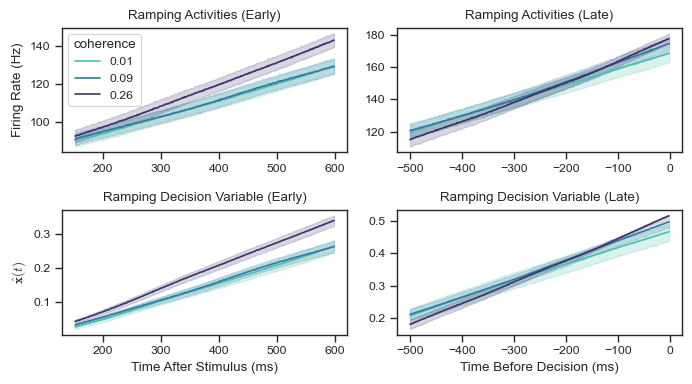

In [5]:
coherences = [0.01, 0.09, 0.26]
dt_sample = 0.02
trials = 30
end_condition = "action"
name = f"spikes_{dt_sample}_{end_condition}"
scan_coherence_spikes(coherences=coherences, dt_sample=dt_sample, trials=trials, end_condition=end_condition, name=name,
                     t_start=0.5, t_end=0.5)
plot_spikes(name)

trial 0, coherence 0.0, RT 0.812, correct False
trial 1, coherence 0.0, RT 1.012, correct True
trial 2, coherence 0.0, RT 0.961, correct True
trial 3, coherence 0.0, RT 0.875, correct False
trial 4, coherence 0.0, RT 0.963, correct False
trial 5, coherence 0.0, RT 1.053, correct False
trial 6, coherence 0.0, RT 0.928, correct True
trial 7, coherence 0.0, RT 1.0170000000000001, correct True
trial 8, coherence 0.0, RT 1.085, correct False
trial 9, coherence 0.0, RT 0.917, correct True
trial 10, coherence 0.0, RT 1.006, correct True
trial 11, coherence 0.0, RT 0.875, correct False
trial 12, coherence 0.0, RT 0.804, correct True
trial 13, coherence 0.0, RT 1.077, correct False
trial 14, coherence 0.0, RT 1.102, correct False
trial 15, coherence 0.0, RT 1.006, correct True
trial 16, coherence 0.0, RT 1.034, correct False
trial 17, coherence 0.0, RT 0.004, correct True
trial 18, coherence 0.0, RT 1.065, correct False
trial 19, coherence 0.0, RT 1.042, correct True
trial 20, coherence 0.0, RT

trial 16, coherence 0.5, RT 0.792, correct True
trial 17, coherence 0.5, RT 0.004, correct True
trial 18, coherence 0.5, RT 0.6920000000000001, correct True
trial 19, coherence 0.5, RT 0.6960000000000001, correct True
trial 20, coherence 0.5, RT 0.664, correct True
trial 21, coherence 0.5, RT 0.7030000000000001, correct True
trial 22, coherence 0.5, RT 0.853, correct True
trial 23, coherence 0.5, RT 0.758, correct True
trial 24, coherence 0.5, RT 0.758, correct True
trial 25, coherence 0.5, RT 0.733, correct True
trial 26, coherence 0.5, RT 0.772, correct True
trial 27, coherence 0.5, RT 0.7030000000000001, correct True
trial 28, coherence 0.5, RT 0.794, correct True
trial 29, coherence 0.5, RT 0.922, correct True


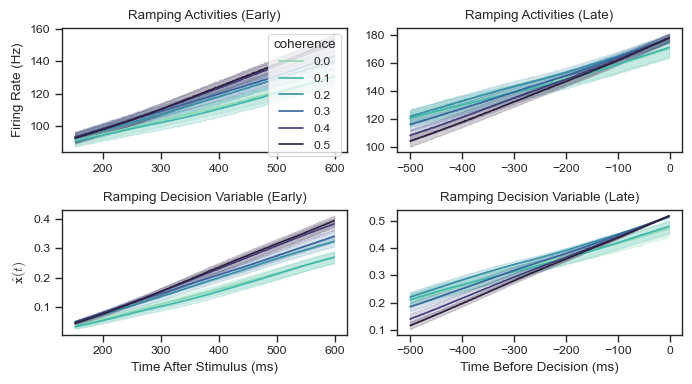

In [6]:
coherences = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
dt_sample = 0.03
trials = 30
end_condition = "action"
name = f"spikes_{dt_sample}_{end_condition}"
scan_coherence_spikes(coherences=coherences, dt_sample=dt_sample, trials=trials, end_condition=end_condition, name=name,
                     t_start=0.5, t_end=0.5)
plot_spikes(name)